# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import AUC
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
%load_ext tensorboard

2023-10-10 22:03:14.052209: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!rm -rf ./logs/

# Loading Dataset

In [4]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0-small/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0-small/valid')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")

There are 1001
There are 201


In [5]:
# Load train and valid labels
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0-small/valid.csv'))

# Load training and validation image paths
train_image_paths = [source_path + '/' + path for path in train_df['Path']]
valid_image_paths = [source_path + '/' + path for path in valid_df['Path']]
# print(train_df.head())     # printing first five rows of the file
# print(train_df.columns)
# print(valid_df.head())     # printing first five rows of the file
# print(valid_df.columns)

# Create TensorFlow tensors from image paths
train_image_paths = tf.constant(train_image_paths)
valid_image_paths = tf.constant(valid_image_paths)

2023-10-10 22:03:45.636621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31125 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


# Creating DataFrames

In [6]:
train_df = train_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
# print(train_df.head())     # printing first five rows of the file
# print(train_df.columns)

In [7]:
valid_df = valid_df[['Path','Frontal/Lateral','Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']]
# print(valid_df.head())     # printing first five rows of the file
# print(valid_df.columns)

# Train and Valid Labels

In [8]:
train_df_UOnes = train_df.replace(-1,1).fillna(0)
print(len(train_df_UOnes))
train_labels = np.array(train_df_UOnes.drop(['Path', 'Frontal/Lateral'], axis=1))

4075


In [9]:
valid_df_UOnes = valid_df.fillna(0)
print(len(valid_df_UOnes))
valid_labels = np.array(valid_df_UOnes.drop(['Path', 'Frontal/Lateral'], axis=1))

234


# Image Preprocessing

In [10]:
from tqdm import tqdm
from keras.preprocessing import image

#training images preprocessing
SIZE = 320

# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to a fixed size
    image = tf.image.resize(image, [SIZE, SIZE])
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [11]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))

In [12]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Visualize Sample Image

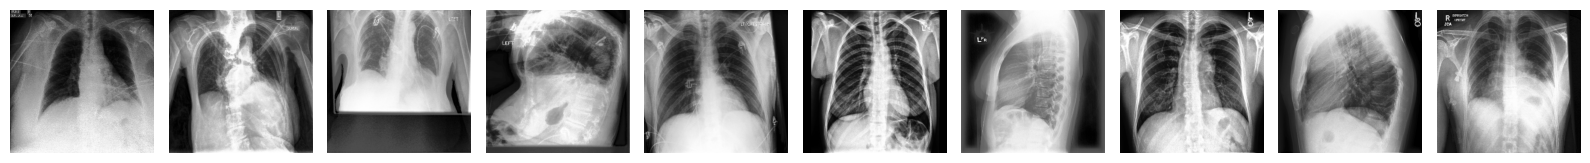

In [13]:
# Plot a sample of 10 original images
fig, axes = plt.subplots(1, 10, figsize=(16, 15))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds.take(10)):
    ax = axes[i]
    ax.imshow(image.numpy())  # Select the first image from the batch
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Augementation

In [14]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
])

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)
    ds = ds.cache()

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)

# Visualize Augmented Images

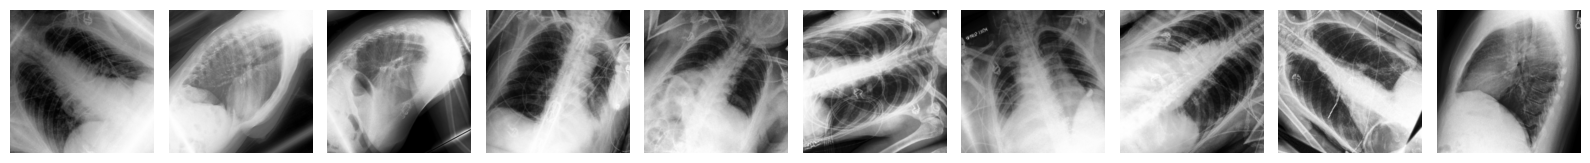

2023-10-10 22:04:12.339899: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
import matplotlib.pyplot as plt

# Define a function to plot sample images
def plot_sample_images(dataset, num_samples=10):
    # Create an iterator for the dataset
    iterator = iter(dataset)

    # Get the next batch of images and labels
    sample_images, sample_labels = next(iterator)

    # Plot the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 15))
    axes = axes.flatten()

    for i in range(num_samples):
        img = sample_images[i]
        ax = axes[i]
        ax.imshow(img.numpy())  # Convert TensorFlow tensor to NumPy array for plotting
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
plot_sample_images(train_ds, num_samples=10)


# Build the Model

In [18]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.densenet import DenseNet121
import tensorflow as tf

# Define a function to create the model within the MirroredStrategy scope
def create_model():
    model = tf.keras.models.Sequential()
    pre_trained_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(320, 320, 3)
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    model.add(pre_trained_model)
    model.add(GlobalAveragePooling2D(input_shape=(1024, 1, 1)))
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=5, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=5)])

    return model

# Train the Model

In [19]:
import time

def create_callbacks():
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = "logs/fit/uonescheckpoint"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    class SaveCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir, save_interval):
            super(SaveCheckpointCallback, self).__init__()
            self.checkpoint_dir = checkpoint_dir
            self.save_interval = save_interval
            self.iteration = 0

        def on_batch_end(self, batch, logs=None):
            self.iteration += 1
            if self.iteration % self.save_interval == 0:
                model_checkpoint = os.path.join(self.checkpoint_dir, f"model_checkpoint_{self.iteration}.h5")
                self.model.save(model_checkpoint)
                print(f"Saved checkpoint at iteration {self.iteration} to {model_checkpoint}")

    save_interval = 4800  # Adjust this as needed
    checkpoint_callback = SaveCheckpointCallback(checkpoint_dir, save_interval)
    
    return [checkpoint_callback, tensorboard_callback]

In [29]:
# Define the desired pathology index here
trained_models = []

def train(num_runs, train_ds, valid_ds):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session to ensure a fresh start for each run
        tf.keras.backend.clear_session()

        model = create_model()
        callbacks = create_callbacks()

        start = time.time()
        history = model.fit(train_ds, epochs=3, validation_data=valid_ds, batch_size=batch_size, callbacks=callbacks, verbose=2)
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        trained_models.append(model)

    return trained_models

# Define the number of runs
num_runs = 3
training = train(num_runs, train_ds, valid_ds)


Run 1 of 3
Epoch 1/3
255/255 - 24s - loss: 0.7954 - binary_accuracy: 0.5666 - auc: 0.5846 - val_loss: 0.6660 - val_binary_accuracy: 0.6043 - val_auc: 0.6586 - 24s/epoch - 96ms/step
Epoch 2/3
255/255 - 14s - loss: 0.6808 - binary_accuracy: 0.6317 - auc: 0.6263 - val_loss: 0.5895 - val_binary_accuracy: 0.6821 - val_auc: 0.7025 - 14s/epoch - 57ms/step
Epoch 3/3
255/255 - 14s - loss: 0.6207 - binary_accuracy: 0.6709 - auc: 0.6385 - val_loss: 0.5355 - val_binary_accuracy: 0.7436 - val_auc: 0.7069 - 14s/epoch - 55ms/step
Total time for run 1 :  54.67083287239075 seconds
Run 2 of 3
Epoch 1/3
255/255 - 23s - loss: 0.7947 - binary_accuracy: 0.5695 - auc: 0.5853 - val_loss: 0.6136 - val_binary_accuracy: 0.6385 - val_auc: 0.6452 - 23s/epoch - 91ms/step
Epoch 2/3
255/255 - 14s - loss: 0.6869 - binary_accuracy: 0.6270 - auc: 0.6241 - val_loss: 0.5994 - val_binary_accuracy: 0.6880 - val_auc: 0.6525 - 14s/epoch - 57ms/step
Epoch 3/3
255/255 - 16s - loss: 0.6244 - binary_accuracy: 0.6706 - auc: 0.6451

In [30]:
%tensorboard --logdir logs --port 8885

Reusing TensorBoard on port 8885 (pid 3798), started 0:22:36 ago. (Use '!kill 3798' to kill it.)

# Evaluate the model

In [31]:
# Evaluate the models
for i, model in enumerate(trained_models):
    ds = valid_ds
    print(f"Test Accuracy for Model {i + 1}: ", model.evaluate(ds))

15/15 [==============================] - 1s 30ms/step - loss: 0.5355 - binary_accuracy: 0.7436 - auc: 0.7069
Test Accuracy for Model 1:  [0.53545081615448, 0.7435898184776306, 0.706872284412384]
15/15 [==============================] - 1s 30ms/step - loss: 0.5485 - binary_accuracy: 0.7239 - auc: 0.6990
Test Accuracy for Model 2:  [0.5485234260559082, 0.7239317297935486, 0.6989800333976746]
15/15 [==============================] - 0s 29ms/step - loss: 0.6718 - binary_accuracy: 0.6453 - auc: 0.6963
Test Accuracy for Model 3:  [0.6717814207077026, 0.6452990770339966, 0.6963306665420532]


In [32]:
import numpy as np

# Initialize empty lists to store predictions and actual labels
all_predictions = []
all_actual_labels = []

# Iterate over the dataset and collect predictions for individual images
for (images, labels) in valid_ds:
    predictions = model.predict(images)  # Get predictions for the current batch of images
    all_predictions.extend(predictions)
    all_actual_labels.extend(labels)

# Convert predictions to 1 if > 0.5, 0 otherwise
threshold = 0.3
rounded_predictions = (np.array(all_predictions) > threshold).astype(int)
actual = np.array(all_actual_labels).astype(int)


# Print the actual labels and predictions for the first 10 images
print("Actual vs. Prediction for the first 10 images:")
for i in range(10):
    prediction_10 = rounded_predictions[i]
    actual_10= np.array(all_actual_labels[i]).astype(int)
    print(f"Actual Labels: {actual_10}")
    print(f"Predictions  : {prediction_10}")
    print()

1/1 [==============================] - 0s 40ms/step
Actual vs. Prediction for the first 10 images:
Actual Labels: [1 0 0 0 0]
Predictions  : [1 1 1 0 0]

Actual Labels: [0 0 0 0 0]
Predictions  : [0 0 0 0 0]

Actual Labels: [0 0 0 0 0]
Predictions  : [0 0 0 0 0]

Actual Labels: [0 1 0 0 0]
Predictions  : [0 1 1 1 1]

Actual Labels: [0 0 0 0 0]
Predictions  : [0 1 0 0 1]

Actual Labels: [0 0 0 1 1]
Predictions  : [1 1 1 1 1]

Actual Labels: [1 0 0 1 0]
Predictions  : [0 1 1 1 1]

Actual Labels: [0 0 0 0 0]
Predictions  : [0 0 1 0 1]

Actual Labels: [0 0 0 0 0]
Predictions  : [1 1 1 0 1]

Actual Labels: [0 0 0 0 0]
Predictions  : [1 0 0 1 1]



In [44]:
# Initialize a counter for counting images
image_count = 0

# Initialize empty lists to store predictions and actual labels
all_predictions = []
all_actual_labels = []

# Initialize an array to store true labels for the specific pathology
true_labels = []

# Iterate over the dataset and collect predictions for individual images
for (images, labels) in valid_ds:
    ensemble_predictions = []  # Store predictions from all trained models
    batch_size = images.shape[0]  # Get the batch size (number of images in the current batch)
    
    for model in trained_models:  # Iterate through the list of trained models
        predictions = model.predict(images)  # Get predictions for the current batch of images
        ensemble_predictions.append(predictions)

    # Compute the ensemble prediction by averaging across models
    ensemble_prediction = np.mean(ensemble_predictions, axis=0)

    all_predictions.extend(ensemble_prediction)
    all_actual_labels.extend(labels)

    # Extend the true_labels array with labels for the current batch
    true_labels.extend(labels) 

    # Increment the image count by the batch size
    image_count += batch_size

# Convert predictions to 1 if > 0.5, 0 otherwise
threshold = 0.3
rounded_predictions = (np.array(all_predictions) > threshold).astype(int)
actual = np.array(all_actual_labels).astype(int)

# Convert true_labels to a 2D array with the same shape as run_predictions
true_labels = np.array(true_labels)

# Print the total count of images processed
print(f"Total number of images processed: {image_count}")


1/1 [==============================] - 0s 48ms/step
Total number of images processed: 234


In [45]:
# Define the number of runs and the number of best checkpoints to consider
from sklearn.metrics import roc_auc_score


num_runs = 3
num_best_checkpoints_per_run = 10
pathology_index = 3

# Iterate over the ensemble predictions for each run
for run_index, run_predictions in enumerate(ensemble_predictions):
    if isinstance(run_predictions, np.ndarray):
        # Extract true labels for the specific pathology
        true_labels = valid_labels[:, pathology_index] 

        # Create an array to store AUROC scores for the best checkpoints
        best_checkpoint_auroc_scores = []

        # Iterate over the best checkpoints
        for checkpoint_index in range(num_best_checkpoints_per_run):
            # Calculate AUROC score for this checkpoint
            auroc = roc_auc_score(true_labels, run_predictions[:, checkpoint_index])
            best_checkpoint_auroc_scores.append(auroc)

        # Calculate the mean AUROC score for the best checkpoints
        mean_auroc = np.mean(best_checkpoint_auroc_scores)
        auroc_scores_list.append(mean_auroc)
    else:
        print(f"Warning: No predictions found for run {run_index}. Skipping run.")

# Check if any AUROC scores were computed
if not auroc_scores_list:
    print("Error: No AUROC scores computed. Please check your data and predictions.")
else:
    # Calculate the 95% confidence interval for the average AUROC scores
    confidence_interval = np.percentile(auroc_scores_list, [2.5, 97.5])

    print(f"Average AUROC Score for Pathology {pathology_index}: {np.mean(auroc_scores_list):.4f}")
    print(f"95% Confidence Interval: {confidence_interval[0]:.4f} - {confidence_interval[1]:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [234, 10]

# AUC and ROC curve

In [ ]:
# Actual vs Predicted per Pathology

column = 3      # 0-Cardiomegaly, 1-Edema, 2-Consolidation, 3-Atelectasis, 4-Pleural Effusion 

pred_pathology = rounded_predictions[:,column]
actual_pathology = actual[:,column]

print(f"pred_pathology: {pred_pathology}")
print(f"actual_pathology: {actual_pathology}")

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def plot_rpc(recall, precision):
    plt.plot(recall, precision, color='orange', label='RPC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(actual_pathology, pred_pathology)

# Ensure that thresholds have the same length as tpr and fpr
thresholds = thresholds[:len(tpr)]

# Plot ROC curve
plot_roc_curve(fpr, tpr)

# Compute the Area Under the ROC Curve (AUC)
roc_auc_score = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc_score}")

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(actual_pathology, pred_pathology)

# Ensure that thresholds have the same length as precision and recall
thresholds = thresholds[:len(precision)]

# Plot Precision-Recall curve
plot_rpc(recall, precision)

# Compute the Area Under the Precision-Recall Curve (AUC)
pr_auc_score = auc(recall, precision)
print(f"Precision-Recall AUC Score (AP): {pr_auc_score}")


In [ ]:
# Confusion Matrix

cm=confusion_matrix(actual_pathology, pred_pathology)  
print(cm)

In [ ]:
# Finding the Ideal Threshold
i = np.arange(len(tpr))
roc_diff = tpr - (1 - fpr)

if len(thresholds) == 1:
    ideal_threshold = thresholds[0]
else:
    ideal_threshold_index = np.argmax(roc_diff)
    ideal_threshold = thresholds[ideal_threshold_index]

print("Ideal threshold is:", ideal_threshold)
